In [1]:
import sys
import os

import numpy as np
from process_bigraph import Composite
from IPython.display import Image
from simulariumio import (
    TrajectoryConverter, 
    TrajectoryData, 
    AgentData, 
    UnitData, 
    MetaData, 
    ModelMetaData,
    CameraData, 
    DisplayData,
    DISPLAY_TYPE,
)

from biosimulator_processes import CORE 

sys.path.insert(0, '..')


model_fp = './examples/smoldyn/MinE.txt'
os.path.exists(model_fp)

doc = {
    'state': {
        'smoldyn': {
            '_type': 'process',
            'address': 'local:smoldyn-process',
            'config': {'model_filepath': model_fp},
            'inputs': {
                'species_counts': ['species_counts'],
                'molecules': ['molecules']
            },
            'outputs': {
                'species_counts': ['species_counts'],
                'molecules': ['molecules']
            }
        },
        'emitter': {
            '_type': 'step',
            'address': 'local:ram-emitter',
            'config': {
                'emit': {
                    'species_counts': 'tree[any]',
                    'molecules': 'tree[any]'
                }
            },
            'inputs': {
                'species_counts': ['species_counts'],
                'molecules': ['molecules']
            }
        }
    }
}

Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra-process',
  'copasi-process',
  'tellurium-process',
  'utc-amici',
  'utc-copasi',
  'utc-tellurium',
  'smoldyn-process',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d',
  'utc-comparator',
  'simple-neuron',
  'simple-neuron-network']


In [2]:
# -- output data --

def get_results(composite_document: dict, duration: int, core=None):
    c = core or CORE 
    
    wf = Composite(config=composite_document, core=c)
    wf.run(duration)
    
    result = wf.gather_results()
    results = {'data': result[('emitter',)]}
    
    sim = wf.state['smoldyn']['instance'].simulation 
    results['dt'] = sim.dt  # TODO: make this more generalized
    results['simulation'] = sim
    return results


def get_max_coord(mol_positions):
    def get_max(dim_index: int, positions: np.ndarray) -> np.ndarray:
        return np.max([mol[dim_index] for mol in mol_positions])
    
    return np.max([get_max(i, mol_positions) for i in [0, 1, 2]])


def get_box_size(mol_positions):
    a = get_max_coord(mol_positions)
    return 6 * (a ** 2)


def set_parameters(composite_document: dict, duration: int, radmin: float, radmax: float):
    output_data = get_results(composite_document, duration)
    type_names = get_type_names(output_data)
    n_agents = get_n_agents(output_data)
    mol_positions = get_molecule_positions(output_data)
    box_size = get_box_size(mol_positions)
    
    return {
        'n_steps': duration,
        'dt': output_data['dt'],
        'box_size': box_size,
        'n_agents': n_agents,
        'radmin': radmin,
        'radmax': radmax
    }


def get_type_names(output_data: dict) -> list[list[str]]:
    return [list(interval_data['species_counts'].keys()) for interval_data in output_data['data']]  # this accounts for 0th measurement! TODO: you might have to factor in time over range.


def get_n_agents(output_data: dict) -> int:
    return sum([sum(list(interval_data['species_counts'].values())) for interval_data in output_data['data']])


def get_molecule_positions(output: dict) -> np.ndarray:
    mol_positions = []
    for interval_data in output['data']:
        molecule_data = interval_data['molecules']
        for mol_data in molecule_data.values():
            mol_positions.append(mol_data['coordinates'])
    
    return np.array(mol_positions)


# -- simularium metadata --

def generate_metadata(title: str, box_size):
    return MetaData(
            box_size=np.array([box_size, box_size, box_size]),
            camera_defaults=CameraData(
                position=np.array([10.0, 0.0, 200.0]),
                look_at_position=np.array([10.0, 0.0, 0.0]),
                fov_degrees=60.0,
            ),
            trajectory_title=title,
            model_meta_data=ModelMetaData(
                title="Some agent-based model",
                version="8.1",
                authors="A Modeler",
                description=(
                    title
                ),
                doi="10.1016/j.bpj.2016.02.002",
                source_code_url="https://github.com/simularium/simulariumio",
                source_code_license_url="https://github.com/simularium/simulariumio/blob/main/LICENSE",
                input_data_url="https://allencell.org/path/to/native/engine/input/files",
                raw_output_data_url="https://allencell.org/path/to/native/engine/output/files",
            ),
        )


# -- simularium agent data based on outputs --

def generate_agent_data(times, n_agents, total_steps, type_names, outputs: dict, box_size, radmin, radmax, display_data: DisplayData):
    agent_data = AgentData(
        times=times, 
        n_agents=n_agents,  # n species or molecules?
        viz_types=np.array(total_steps * [n_agents * [1000.0]]),
        unique_ids=np.array(total_steps * [list(range(n_agents))]),
        types=type_names,
        positions=[]
        
    )
    pass 
    

In [3]:
duration = 2 
min_radius = 0.001
max_radius = 0.009

parameters = set_parameters(doc, duration, min_radius, max_radius)

timestep = parameters['dt']
times = np.array(timestep * np.array(list(range(duration + 1))))

metadata = generate_metadata("Min1", parameters['box_size'])

Libsmoldyn notification from smolRunSim: Simulation complete
Libsmoldyn notification from smolRunSim: Simulation complete


In [4]:
parameters

{'n_steps': 2,
 'dt': 0.002,
 'box_size': 23.999962610764637,
 'n_agents': 9433,
 'radmin': 0.001,
 'radmax': 0.009}

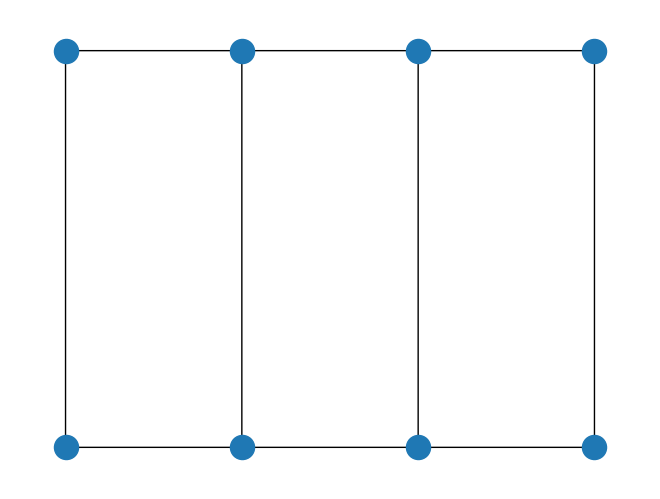

In [1]:
from math import pi

import numpy as np
import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
import numpy as np

# Define the size of the 2D grid lattice (e.g., 3 rows, 4 columns)
size = (4, 2)
boundary_condition = (
    BoundaryCondition.OPEN,  # Boundary conditions for each dimension
    BoundaryCondition.OPEN,
)

# Create the SquareLattice for the 2D grid
square_lattice = SquareLattice(rows=size[0], cols=size[1], boundary_condition=boundary_condition)

# Function to set the positions of the lattice points
def indextocoord_2d(index: int, size: tuple) -> list:
    y = index // size[1]
    x = index % size[1]
    return [x, y]

# Define the positions of the lattice points
pos = dict([(index, indextocoord_2d(index, size)) for index in range(np.prod(size))])

# Draw the square lattice
square_lattice.draw()

{(9, 14, (100+100j)), (10, 10, 1.0), (1, 2, 100.0), (17, 17, 1.0), (14, 14, 1.0), (18, 18, 1.0), (13, 14, 100.0), (4, 4, 1.0), (3, 8, (100+100j)), (7, 12, (100+100j)), (6, 6, 1.0), (18, 19, 100.0), (3, 18, (100-100j)), (15, 15, 1.0), (11, 16, (100+100j)), (6, 7, 100.0), (10, 11, 100.0), (0, 0, 1.0), (19, 19, 1.0), (1, 16, (100-100j)), (0, 1, 100.0), (8, 13, (100+100j)), (12, 17, (100+100j)), (15, 16, 100.0), (5, 10, (100+100j)), (2, 2, 1.0), (9, 9, 1.0), (11, 11, 1.0), (2, 3, 100.0), (3, 3, 1.0), (1, 6, (100+100j)), (0, 15, (100-100j)), (7, 7, 1.0), (13, 18, (100+100j)), (4, 19, (100-100j)), (5, 9, 100.0), (10, 15, (100+100j)), (14, 19, (100+100j)), (7, 8, 100.0), (11, 12, 100.0), (17, 18, 100.0), (8, 8, 1.0), (6, 11, (100+100j)), (12, 12, 1.0), (16, 16, 1.0), (3, 4, 100.0), (10, 14, 100.0), (12, 13, 100.0), (0, 5, (100+100j)), (4, 9, (100+100j)), (0, 4, 100.0), (5, 5, 1.0), (16, 17, 100.0), (5, 6, 100.0), (2, 17, (100-100j)), (8, 9, 100.0), (15, 19, 100.0), (2, 7, (100+100j)), (1, 1, 

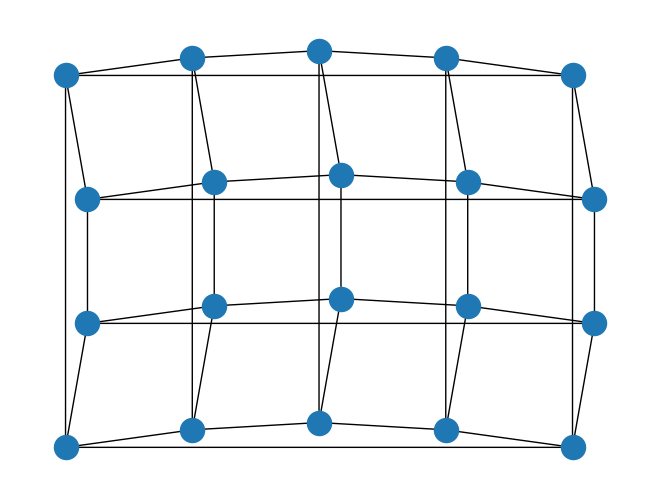

In [4]:
# Define the grid size
rows = 5
cols = 4
boundary_condition = (
    BoundaryCondition.PERIODIC,  # Periodic in the x-direction
    BoundaryCondition.PERIODIC,  # Periodic in the y-direction
)

# Define the tempo of the metronomes
tempo = 100  # Example tempo value, can be adjusted

# Define edge parameters as a function of tempo
edge_parameter = (1.0 * tempo, (1.0 + 1.0j) * tempo)  # Adjust weights based on tempo
onsite_parameter = 1.0  # Onsite parameter for self-loops

# Create the SquareLattice
square_lattice = SquareLattice(
    rows=rows,
    cols=cols,
    edge_parameter=edge_parameter,
    onsite_parameter=onsite_parameter,
    boundary_condition=boundary_condition,
)

# Retrieve and print the weighted edge list
weighted_edges = set(square_lattice.graph.weighted_edge_list())
print(weighted_edges)

# Draw the lattice
square_lattice.draw()

In [12]:
from qiskit_nature.second_q.problems import LatticeModelProblem

from qiskit_nature.second_q.hamiltonians import IsingModel

ising_model = IsingModel(
    square_lattice.uniform_parameters(
        uniform_interaction=-1.0,
        uniform_onsite_potential=0.0,
    ),
)

lmp = LatticeModelProblem(ising_model)

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

numpy_solver = NumPyMinimumEigensolver()

qubit_mapper = JordanWignerMapper()

calc = GroundStateEigensolver(qubit_mapper, numpy_solver)
res = calc.solve(lmp)

print(res)

QiskitNatureError: "FermionicOp label included 'Z'. Allowed characters: I, N, E, +, -"

In [ ]:


# Define the Hamiltonian as a PauliSumOp
# Mapping the Max-Cut problem to Ising model: {34, 53, 23, 52, 14}
hamiltonian = PauliSumOp.from_list([
    ('Z_3 Z_4', -1.0 * tempo),  # Edge between nodes 3 and 4
    ('Z_5 Z_3', -1.0 * tempo),  # Edge between nodes 5 and 3
    ('Z_2 Z_3', -1.0 * tempo),  # Edge between nodes 2 and 3
    ('Z_5 Z_2', -1.0 * tempo),  # Edge between nodes 5 and 2
    ('Z_1 Z_4', -1.0 * tempo),  # Edge between nodes 1 and 4
])

# Add the subharmonic injection influence
# Assuming it influences all nodes equally, we add Z terms for each node.
hamiltonian += PauliSumOp.from_list([
    ('Z_0', 0.1), ('Z_1', 0.1), ('Z_2', 0.1), ('Z_3', 0.1), ('Z_4', 0.1), ('Z_5', 0.1)
])

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

# Define a quantum instance using the Aer simulator
quantum_instance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'))

# Define a variational form (ansatz)
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=3)

# Define an optimizer
optimizer = COBYLA(maxiter=100)

# Create a VQE instance
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the ground state
result = vqe.compute_minimum_eigenvalue(hamiltonian)

# Get the optimal parameters and corresponding energy
optimal_params = result.optimal_point
optimal_energy = result.optimal_value

print(f'Optimal Energy: {optimal_energy}')
print(f'Optimal Parameters: {optimal_params}')


optimal_spin_config = np.sign(np.round(np.cos(optimal_params)))

print(f'Optimal Spin Configuration: {optimal_spin_config}')

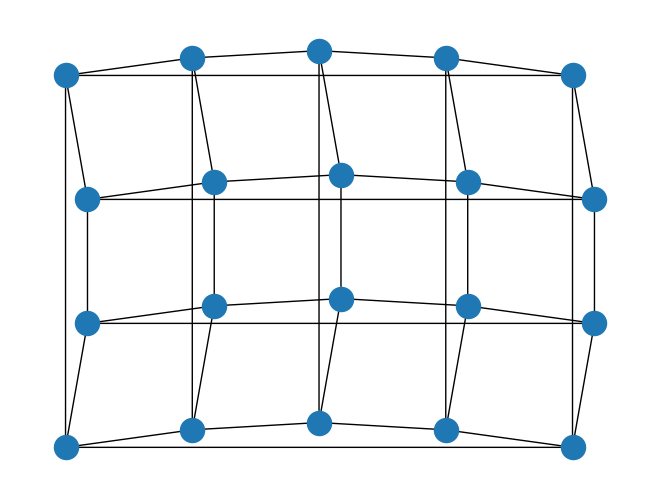

In [5]:
def adjust_for_subharmonic(edge_param, subharmonic_influence):
    return tuple(param * subharmonic_influence for param in edge_param)

# Define the influence of the subharmonic injection (e.g., factor of 2 for frequency 2f)
subharmonic_influence = 2.0

# Adjust the edge parameters accordingly
adjusted_edge_parameter = adjust_for_subharmonic(edge_parameter, subharmonic_influence)

# Create the SquareLattice with adjusted parameters
square_lattice = SquareLattice(
    rows=rows,
    cols=cols,
    edge_parameter=adjusted_edge_parameter,
    onsite_parameter=onsite_parameter,
    boundary_condition=boundary_condition,
)

# Draw the adjusted lattice
square_lattice.draw()

In [8]:
ising_model.second_q_op()

SpinOp({'Z_0 Z_1': -1.0, 'Z_0 Z_5': -1.0, 'Z_5 Z_6': -1.0, 'Z_5 Z_10': -1.0, 'Z_10 Z_11': -1.0, 'Z_10 Z_15': -1.0, 'Z_15 Z_16': -1.0, 'Z_1 Z_2': -1.0, 'Z_1 Z_6': -1.0, 'Z_6 Z_7': -1.0, 'Z_6 Z_11': -1.0, 'Z_11 Z_12': -1.0, 'Z_11 Z_16': -1.0, 'Z_16 Z_17': -1.0, 'Z_2 Z_3': -1.0, 'Z_2 Z_7': -1.0, 'Z_7 Z_8': -1.0, 'Z_7 Z_12': -1.0, 'Z_12 Z_13': -1.0, 'Z_12 Z_17': -1.0, 'Z_17 Z_18': -1.0, 'Z_3 Z_4': -1.0, 'Z_3 Z_8': -1.0, 'Z_8 Z_9': -1.0, 'Z_8 Z_13': -1.0, 'Z_13 Z_14': -1.0, 'Z_13 Z_18': -1.0, 'Z_18 Z_19': -1.0, 'Z_4 Z_9': -1.0, 'Z_9 Z_14': -1.0, 'Z_14 Z_19': -1.0, 'X_0': 0.0, 'X_1': 0.0, 'X_2': 0.0, 'X_3': 0.0, 'X_4': 0.0, 'X_5': 0.0, 'X_6': 0.0, 'X_7': 0.0, 'X_8': 0.0, 'X_9': 0.0, 'X_10': 0.0, 'X_11': 0.0, 'X_12': 0.0, 'X_13': 0.0, 'X_14': 0.0, 'X_15': 0.0, 'X_16': 0.0, 'X_17': 0.0, 'X_18': 0.0, 'X_19': 0.0, 'Z_0 Z_4': -1.0, 'Z_5 Z_9': -1.0, 'Z_10 Z_14': -1.0, 'Z_15 Z_19': -1.0, 'Z_0 Z_15': -1.0, 'Z_1 Z_16': -1.0, 'Z_2 Z_17': -1.0, 'Z_3 Z_18': -1.0, 'Z_4 Z_19': -1.0}, spin=1/2, num_spins=2

In [ ]:
from dataclasses import dataclass

from biosimulator_processes.data_model import _BaseClass

@dataclass
class IsingNode(_BaseClass):
    value: float
    name: str 
    connections: list[str]  # index by node name, then the value can be looked up.
    
@dataclass
class Edge(_BaseClass):
    value: float 
    nodes: list[IsingNode]
    


# monte carlo
def initialize_lattice(): pass 

def equilibrate_lattice(): pass 

 

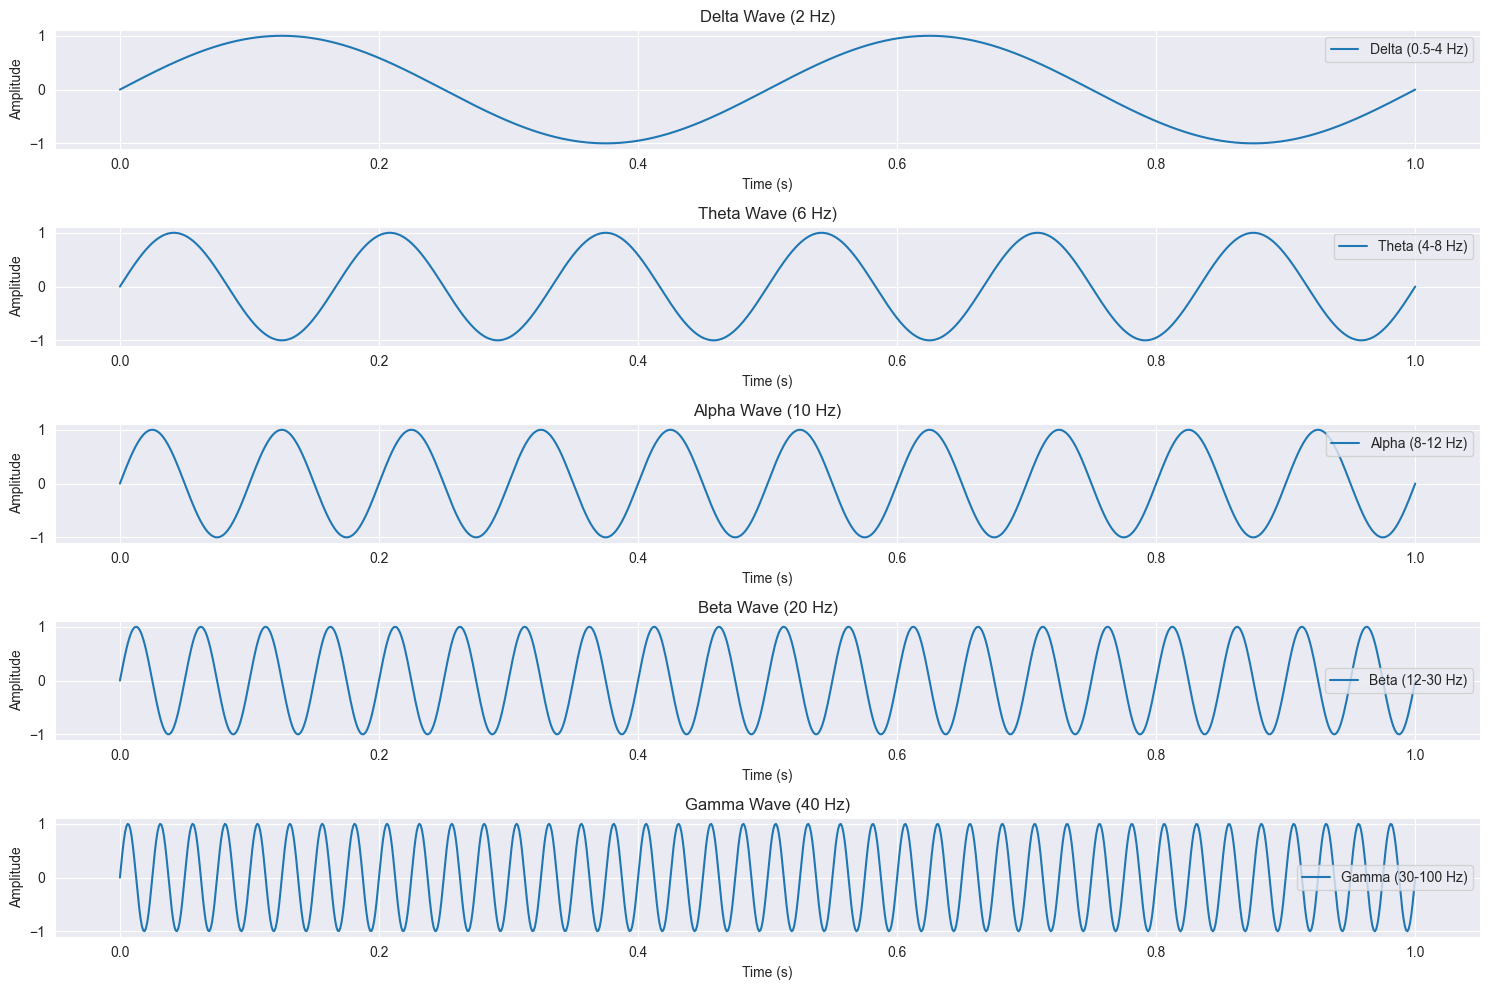

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling rate and time vector
sampling_rate = 1000  # in Hz
t = np.linspace(0, 1, sampling_rate)  # 1 second of data

# Generate the different brain waveforms
delta_wave = np.sin(2 * np.pi * 2 * t)  # 2 Hz delta wave
theta_wave = np.sin(2 * np.pi * 6 * t)  # 6 Hz theta wave
alpha_wave = np.sin(2 * np.pi * 10 * t)  # 10 Hz alpha wave
beta_wave = np.sin(2 * np.pi * 20 * t)  # 20 Hz beta wave
gamma_wave = np.sin(2 * np.pi * 40 * t)  # 40 Hz gamma wave

# Plot each waveform
plt.figure(figsize=(15, 10))

plt.subplot(5, 1, 1)
plt.plot(t, delta_wave, label='Delta (0.5-4 Hz)')
plt.title('Delta Wave (2 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(t, theta_wave, label='Theta (4-8 Hz)')
plt.title('Theta Wave (6 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(t, alpha_wave, label='Alpha (8-12 Hz)')
plt.title('Alpha Wave (10 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(t, beta_wave, label='Beta (12-30 Hz)')
plt.title('Beta Wave (20 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(t, gamma_wave, label='Gamma (30-100 Hz)')
plt.title('Gamma Wave (40 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import random 

np.random.random(4)


array([0.11627455, 0.70155909, 0.46605659, 0.46527029])

In [2]:
sum(np.random.random(3))

2.224811237187018

In [ ]:
"""
AND 
a | b | y 
0   0   0 
0   1   0 
1   0   0 
1   1   1 


OR
a | b | y
0   0   0
0   1   1 
1   0   1  
1   1   1 


XOR
a | b | y
0   0   0 
0   1   1
1   0   1 
1   1   0 


NOT
a | y
0   1  
1   0 


YES 
a | y 
0   0 
1   1 

"""

In [41]:
a = 1
b = 0

int(a and b or not a or b)

0

In [18]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import * 


@dataclass
class Gate(ABC): 
    inputs: Tuple[int, int]
    label: str = None
    output: int = None 
    
    def __post_init__(self):
        self.output = self.operate(self.inputs)
    
    @abstractmethod
    def operate(self, inputs: Tuple[int, int]):
        pass
    
    def _and(self, inputs: Tuple):
        a, b = inputs 
        return int(a and b)
    
    def _or(self, inputs: Tuple):
        """
        a | b | y 
        0   0   0 
        0   1   1 
        1   0   1
        1   1   1 
        """
        a, b = inputs 
        return int(a or b)
    
    def _xor(self, inputs):
        a, b = inputs
        
        
    

@dataclass
class AND(Gate):
    label: str = 'AND'

    def operate(self, inputs: list):
        """
        a | b | y 
        0   0   0 
        0   1   0 
        1   0   0 
        1   1   1 
        """
        a, b = inputs
        return int(a and b)   


def and_gate(inputs: Tuple[int, int]):
    return AND(inputs=inputs).output


and_gate((0, 1))

0

In [11]:
x = 0 
y = 1

int(x and y)

0

In [3]:
def generate_noisy_signal(duration, sampling_rate, noise_level=0.5):
    import numpy as np 
    t = np.linspace(0, duration, int(sampling_rate * duration))

    waves = np.array([
        np.sin(2 * np.pi * (n * 10) * t) * np.random.normal(1, 0.1, len(t)) for n in np.random.random(5)
    ])
    
    # Combine the waves into a composite signal
    composite_signal = waves
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, composite_signal.shape)
    noisy_signal = composite_signal + noise
    
    return t, noisy_signal

In [6]:
input_signal, t = generate_noisy_signal(10000, 1000)

<Axes: >

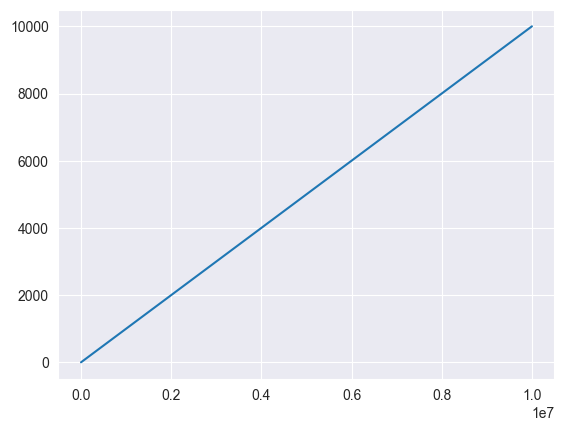

In [7]:
import seaborn as sns 

sns.lineplot(input_signal)

KeyboardInterrupt: 

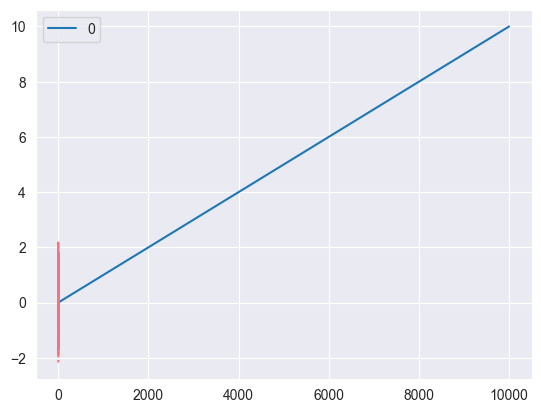

In [9]:
import matplotlib.pyplot as plt 

for i, sig in enumerate(input_signal):
    sns.lineplot(sig, label=str(i))

plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def extract_brain_waves(signal, sampling_rate):
    # Perform FFT
    N = len(signal)
    freqs = np.fft.fftfreq(N, 1/sampling_rate)
    fft_values = np.fft.fft(signal)
    
    # Define frequency bands
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 100)
    }
    
    # Create a plot
    plt.figure(figsize=(10, 4))

    # Plot original signal
    plt.subplot(6, 1, 1)
    plt.plot(np.linspace(0, N/sampling_rate, N), signal)
    plt.title('Original Composite Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Extract and plot frequency components
    time = np.linspace(0, N/sampling_rate, N)
    for i, (band, (low, high)) in enumerate(bands.items(), start=2):
        # Create a mask for the frequencies in the current band
        band_mask = (np.abs(freqs) >= low) & (np.abs(freqs) <= high)
        band_fft_values = np.zeros_like(fft_values)
        band_fft_values[band_mask] = fft_values[band_mask]
        
        # Perform inverse FFT to get the time-domain signal
        band_signal = np.fft.ifft(band_fft_values)
        
        # Plot the band signal
        plt.subplot(6, 1, i)
        plt.plot(time, band_signal.real, label=f'{band} ({low}-{high} Hz)')
        plt.title(f'{band} Wave')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()

    plt.show()

# Example usage
if __name__ == "__main__":
    # Create a composite signal
    duration = 5
    sampling_rate = 1000  # Hz
    t, composite_signal = generate_noisy_signal(duration, sampling_rate)
    
    # Extract and plot the brain waves
    extract_brain_waves(composite_signal, sampling_rate)


ValueError: Image size of 859x105037 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x400 with 6 Axes>

In [ ]:
from process_bigraph import Composite, Process, Step 
from simulariumio

class SimulariumStep(Step):
    config_schema = {
        'data_filepath': 'string',
        'box_size': 'float'
    }

In [ ]:
box_size = 100.

example_data = SmoldynData(
    meta_data=MetaData(
        box_size=np.array([box_size, box_size, box_size]),
        trajectory_title="Some parameter set",
        model_meta_data=ModelMetaData(
            title="Some agent-based model",
            version="8.1",
            authors="A Modeler",
            description=(
                "An agent-based model run with some parameter set"
            ),
            doi="10.1016/j.bpj.2016.02.002",
            source_code_url="https://github.com/simularium/simulariumio",
            source_code_license_url="https://github.com/simularium/simulariumio/blob/main/LICENSE",
            input_data_url="https://allencell.org/path/to/native/engine/input/files",
            raw_output_data_url="https://allencell.org/path/to/native/engine/output/files",
        ),
    ),
    smoldyn_file=InputFileData(
        file_path="../simulariumio/tests/data/smoldyn/example_3D.txt"
    ),
    display_data={
        "red(solution)": DisplayData(
            name="B",
            radius=1.0,
            display_type=DISPLAY_TYPE.OBJ,
            url="b.obj",
            color="#dfdacd",
        ),
        "green(solution)": DisplayData(
            name="A",
            radius=2.0,
            display_type=DISPLAY_TYPE.SPHERE,
            color="#0080ff",
        ),
    },
    time_units=UnitData("ns"),  # nanoseconds
    spatial_units=UnitData("nm"),  # nanometers
    center=True,
)